In [4]:
import numpy as np # linear algebra
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings 
import copy 

In [5]:
import pickle

# 加载数据

with open('ehr_preprocessed_seq_by_day_cat_embedding.pkl', 'rb') as f:
  ehr_data = pickle.load(f)

ehr_data.keys()

dict_keys(['feat_dict', 'feature_cols', 'cat_idxs', 'cat_dims', 'demo_cols', 'icd_cols', 'lab_cols', 'med_cols'])

In [2]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

In [6]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import find_peaks

# -------- Step 1: Custom Dataset Class -------- #

class CustomDataset(Dataset):
    def __init__(self, dataframe, feat_dict):
        """
        Custom PyTorch Dataset to handle feature extraction and normalization.
        :param dataframe: Pandas DataFrame with patient IDs and labels.
        :param feat_dict: Dictionary mapping patient IDs to their feature arrays.
        """
        self.df = dataframe.drop_duplicates(subset=['id'], keep='first')  # Ensure unique IDs
        self.feat_dict = feat_dict
        self.mean, self.std = self.compute_stats()  # Compute mean and std for normalization

    def compute_stats(self):
        """
        Compute the mean and standard deviation across all features for normalization.
        """
        selected_features = torch.cat([torch.tensor(self.feat_dict[id][:, :], dtype=torch.float32)
                                       for id in self.df['id']])
        mean = selected_features.mean(dim=0)
        std = selected_features.std(dim=0)
        return mean, std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieve a data sample (features and label) by index.
        """
        row = self.df.iloc[idx]
        features = torch.tensor(self.feat_dict[row['id']][:, :], dtype=torch.float32)
        label = row['readmitted_within_30days'] if 'readmitted_within_30days' in self.df.columns else -1

        # Normalize features
        features = (features - self.mean) / (self.std + 1e-6)  # Avoid division by zero
        return features, torch.tensor(label, dtype=torch.long)


# -------- Step 2: Feature Extraction Functions -------- #

def extract_statistical_features(features):
    """
    Extract enhanced statistical features from time-series data.
    :param features: Tensor of shape (time_steps, num_features)
    :return: Tensor of shape (num_features * num_statistics,)
    """
    features_np = features.numpy()

    # Basic statistics
    mean = features.mean(dim=0)
    std = features.std(dim=0)
    min_val = features.min(dim=0).values
    max_val = features.max(dim=0).values
    var = features.var(dim=0)
    median = torch.median(features, dim=0).values
    range_val = max_val - min_val

    # Advanced statistics
    skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
    kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
    energy = torch.sum(features ** 2, dim=0)

    # Safeguard for entropy: Ensure no negative or zero values
    features_np_safe = np.clip(features_np, a_min=1e-12, a_max=None)
    signal_entropy = torch.tensor(entropy(features_np_safe.T, axis=1))

    # Concatenate all statistical features
    statistics = torch.cat([mean, std, min_val, max_val, var, median, range_val, skewness, kurt, energy, signal_entropy], dim=0)

    # Replace NaN, inf, or -inf with 0
    statistics[~torch.isfinite(statistics)] = 0

    return statistics


def extract_temporal_features(features):
    """
    Extract temporal features from time-series data.
    :param features: Tensor of shape (time_steps, num_features)
    :return: Tensor of shape (num_features * num_temporal_features,)
    """
    features_np = features.numpy()

    # Autocorrelation for lag 1 (handle errors gracefully)
    autocorr = []
    for i in range(features_np.shape[1]):
        try:
            autocorr_value = np.corrcoef(features_np[:-1, i], features_np[1:, i])[0, 1]
        except:
            autocorr_value = 0  # Default to 0 if computation fails
        autocorr.append(autocorr_value)
    autocorr = torch.tensor(autocorr)

    # Rolling mean (window size = 3)
    rolling_mean = torch.tensor(pd.DataFrame(features_np).rolling(window=3, min_periods=1).mean().iloc[-1].values)

    # Peak detection
    peaks = torch.tensor([len(find_peaks(features_np[:, i])[0]) for i in range(features_np.shape[1])])

    # Combine temporal features
    temporal_features = torch.cat([autocorr, rolling_mean, peaks], dim=0)

    # Replace NaN, inf, or -inf with 0
    temporal_features[~torch.isfinite(temporal_features)] = 0

    return temporal_features


def extract_features(features):
    """
    Combines statistical and temporal features for feature extraction.
    :param features: Tensor of shape (time_steps, num_features)
    :return: Tensor of combined features
    """
    statistical_features = extract_statistical_features(features)
    temporal_features = extract_temporal_features(features)
    combined_features = torch.cat([statistical_features, temporal_features], dim=0)
    return combined_features


# -------- Step 3: Batch Feature Extraction -------- #

def clean_features(features):
    """
    Ensures that all feature values are finite (no inf, -inf, or NaN).
    :param features: NumPy array of extracted features
    :return: Cleaned NumPy array
    """
    # Replace NaN, inf, and -inf with 0
    features[~np.isfinite(features)] = 0
    return features


def extract_features_and_labels(dataset, batch_size=128):
    """
    Extract features and labels from a PyTorch Dataset in batches.
    :param dataset: PyTorch Dataset object
    :param batch_size: Number of samples per batch
    :return: features_array, labels_array
    """
    features_list = []
    labels_list = []

    for i in range(0, len(dataset), batch_size):
        batch = [dataset[j] for j in range(i, min(i + batch_size, len(dataset)))]
        features_batch = torch.stack([extract_features(features) for features, _ in batch])
        labels_batch = torch.tensor([label for _, label in batch])

        # Convert features to NumPy and clean them
        features_cleaned = clean_features(features_batch.numpy())
        features_list.append(features_cleaned)
        labels_list.append(labels_batch.numpy())

    features_array = np.concatenate(features_list)
    labels_array = np.concatenate(labels_list)

    return features_array, labels_array


# -------- Step 4: Feature Scaling -------- #

def scale_features(train_features, valid_features, test_features):
    """
    Scale features using StandardScaler.
    """
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    valid_features_scaled = scaler.transform(valid_features)
    test_features_scaled = scaler.transform(test_features)
    return train_features_scaled, valid_features_scaled, test_features_scaled


# -------- Main Workflow -------- #

# Assuming ehr_data, df_train, df_valid, df_test are already loaded
feat_dict = ehr_data['feat_dict']

# Create PyTorch Dataset objects
train_dataset = CustomDataset(df_train, feat_dict)
valid_dataset = CustomDataset(df_valid, feat_dict)
test_dataset = CustomDataset(df_test, feat_dict)

# Extract features and labels
train_features, train_labels = extract_features_and_labels(train_dataset)
valid_features, valid_labels = extract_features_and_labels(valid_dataset)
test_features, test_labels = extract_features_and_labels(test_dataset)

# Ensure all features are finite (clean again after extraction)
train_features = clean_features(train_features)
valid_features = clean_features(valid_features)
test_features = clean_features(test_features)

# Scale features
train_features_scaled, valid_features_scaled, test_features_scaled = scale_features(
    train_features, valid_features, test_features
)

# At this point, you have:
# - `train_features_scaled`, `valid_features_scaled`, `test_features_scaled`: Scaled feature arrays
# - `train_labels`, `valid_labels`, `test_labels`: Corresponding labels

/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17495/2280458276.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return features, torch.tensor(label, dtype=torch.long)
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17495/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17495/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarn

In [7]:
def extract_label(patient_data):
    return patient_data['label']

/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Predicting on validation set: 100%|██████████| 2788/2788 [00:00<00:00, 2993.29it/s]


ROC-AUC on the validation set: 0.7720496329078904


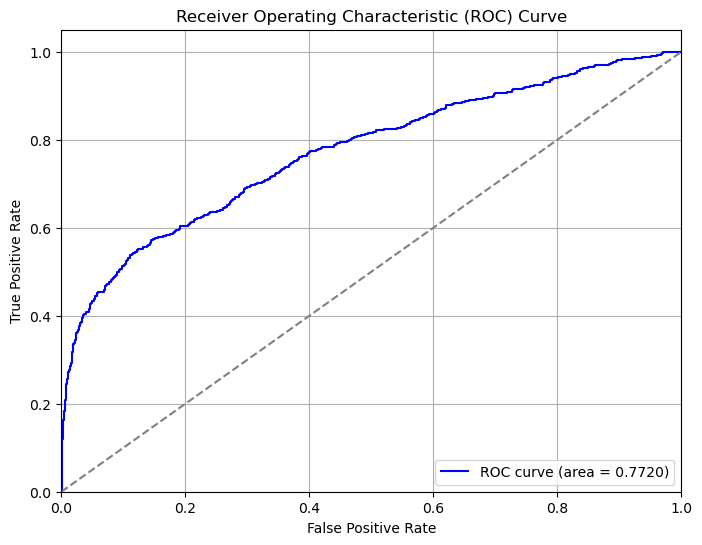

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming you have already loaded and preprocessed your data
# Example: train_features, train_labels, valid_features, valid_labels

# Standardize the features (feature scaling)
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and validation data
train_features_scaled = scaler.fit_transform(train_features)
valid_features_scaled = scaler.transform(valid_features)

# Define logistic regression parameters
params = {
    'solver': 'saga',
    'max_iter': 100,
    'C': 1e10,
    'penalty': "l1",
    'class_weight': 'balanced'
}

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(**params)

# Train the model on the scaled training data
logreg_model.fit(train_features_scaled, train_labels)

# Predict probabilities on the validation set with tqdm progress bar
predicted_probabilities_valid = []
for features in tqdm(valid_features_scaled, desc='Predicting on validation set'):
    predicted_probabilities_valid.append(logreg_model.predict_proba(features.reshape(1, -1))[:, 1])

# Convert the list to a flattened NumPy array
predicted_probabilities_valid = np.array(predicted_probabilities_valid).flatten()

# Compute ROC-AUC for the Logistic Regression model on the validation set
roc_auc_valid = roc_auc_score(valid_labels, predicted_probabilities_valid)
print(f"ROC-AUC on the validation set: {roc_auc_valid}")


fpr, tpr, thresholds = roc_curve(valid_labels, predicted_probabilities_valid)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_valid:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------- Step 1: Ensure Unique IDs in Test Data -------- #

# Drop duplicate IDs in the test set
df_test_unique = df_test.drop_duplicates(subset=['id'], keep='first')

# Extract features from the test dataset (assuming you've already defined the extract_features_and_labels function)
# We only need the features here, as the test set doesn't have labels
test_features, _ = extract_features_and_labels(test_dataset)

# -------- Step 2: Scale the Test Features -------- #

# Use the same scaler that was fitted on the training data to scale the test features
test_features_scaled = scaler.transform(test_features)

# -------- Step 3: Predict Readmission Probabilities -------- #

# Predict probabilities for the test set using the trained Logistic Regression model
# We are interested in the probability of the positive class (class 1)
predicted_probabilities_test = logreg_model.predict_proba(test_features_scaled)[:, 1]

# -------- Step 4: Check Consistency Between IDs and Predictions -------- #

# Check that the number of unique IDs matches the number of predictions
print(f"Number of unique IDs: {df_test_unique.shape[0]}")
print(f"Number of predictions: {len(predicted_probabilities_test)}")

if df_test_unique.shape[0] != len(predicted_probabilities_test):
    raise ValueError("Mismatch between the number of unique IDs and the number of predictions.")

# -------- Step 5: Save Predictions to CSV -------- #

# Create a DataFrame with 'id' and 'probability_of_readmission'
test_predictions_df = pd.DataFrame({
    'id': df_test_unique['id'],
    'probability_of_readmission': predicted_probabilities_test
})

# Save the predictions to a CSV file
output_csv_filename = 'Logistic_Regression_predictions.csv'
test_predictions_df.to_csv(output_csv_filename, index=False)

print(f"Predictions saved to {output_csv_filename}")

/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17495/2280458276.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = torch.tensor(skew(features_np, axis=0, nan_policy='omit'))
/var/folders/16/l2mzwqvx7c16z83x60ggh59r0000gn/T/ipykernel_17495/2280458276.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = torch.tensor(kurtosis(features_np, axis=0, nan_policy='omit'))
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/taoyichun/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Number of unique IDs: 2741
Number of predictions: 2741
Predictions saved to Logistic_Regression_predictions.csv
